In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point
import geoplot.crs as gcrs
import contextily as cx
import plotly.express as px
from geopandas.tools import overlay

In [17]:
# Kept the original dataset
listingsNYC = pd.read_csv('listings.csv', dtype=object)

# Dropping all of the columns which we will not use
listingsNYC= listingsNYC.drop(['last_review','license','host_name'], axis=1)

# Dropping all rows with any 'Nan' values in them
listingsNYC.dropna(axis=0, how='any', inplace=True)
data_types_dict = {
    'price':'int64', 
    'minimum_nights':'int64', 
    'host_id':str,
    'number_of_reviews':'int64',
    'reviews_per_month':float,
    'calculated_host_listings_count':'int64',
    'availability_365':'int64',
    'number_of_reviews_ltm':'int64',
    'latitude':float,
    'longitude':float,
    
}

#changing all the datatype to their respective types that we can work with
listingsNYC = listingsNYC.astype(data_types_dict)

# creating a price per stay (ppn) column with the price and minimim nights columns and rounding to 2 decimal places. 
# This is a float dtype 
listingsNYC['pps'] = (listingsNYC['price'] * listingsNYC['minimum_nights']).round(2)
listingsNYC = listingsNYC[(listingsNYC['price'] != 0)]
listingsNYC.loc[:,'log_price']=np.log(listingsNYC['price'])

In [18]:
nyc_map = gpd.read_file("neighbourhoods.geojson")
nyc_map

neighbourhood neighbourhood_group  \
0             Bayswater              Queens   
1              Allerton               Bronx   
2           City Island               Bronx   
3      Ditmars Steinway              Queens   
4            Ozone Park              Queens   
..                  ...                 ...   
228  Westchester Square               Bronx   
229         Westerleigh       Staten Island   
230      Williamsbridge               Bronx   
231        Williamsburg            Brooklyn   
232         Willowbrook       Staten Island   

                                              geometry  
0    MULTIPOLYGON (((-73.76671 40.61491, -73.76825 ...  
1    MULTIPOLYGON (((-73.84860 40.87167, -73.84582 ...  
2    MULTIPOLYGON (((-73.78282 40.84392, -73.78257 ...  
3    MULTIPOLYGON (((-73.90160 40.76777, -73.90391 ...  
4    MULTIPOLYGON (((-73.83754 40.69136, -73.83108 ...  
..                                                 ...  
228  MULTIPOLYGON (((-73.84294 40.84640, -73.83913 ...  
229  MULTIPOLYGON (((-74.13131 40.62633, -74.13192 ...  
230  MULTIPOLYGON (((-73.86722 40.86969, -73.86701 ...  
231  MULTIPOLYGON (((-73.95757 40.72510, -73.95300 ...  
232  MULTIPOLYGON (((-74.14707 40.60550, -74.14203 ...  

[233 rows x 3 columns]

In [19]:
nyc_map.to_crs(epsg=3857, inplace=True)

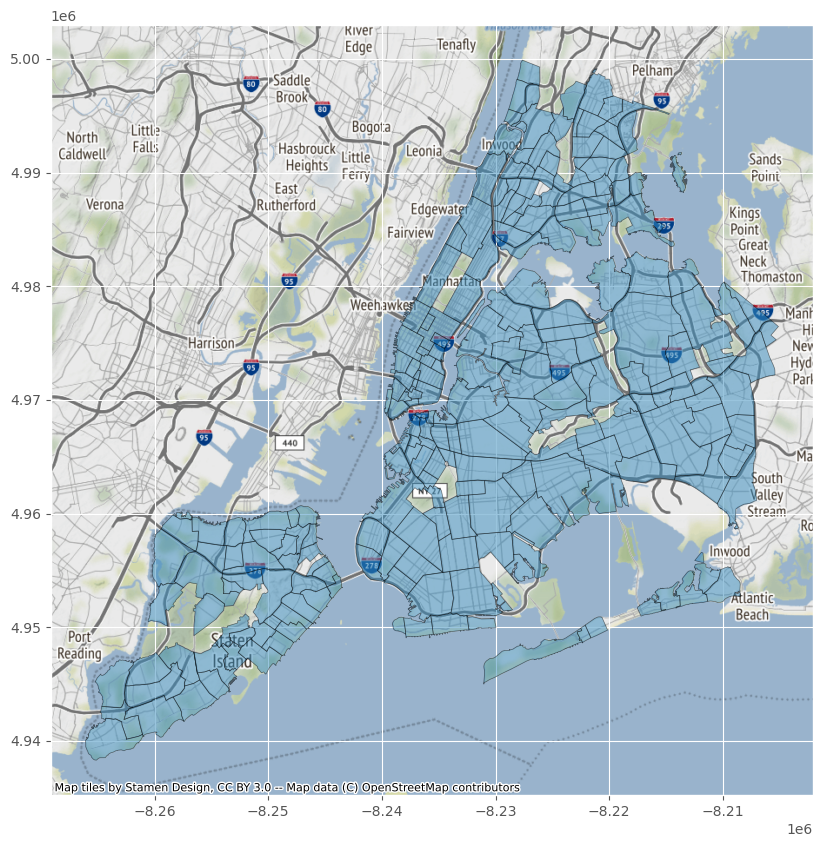

In [20]:
ax=nyc_map.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
nyc_basemap = cx.add_basemap(ax)

In [21]:
neighborhood_counts = listingsNYC.groupby('neighbourhood').count()
neighborhood_counts=neighborhood_counts[['id']]
neighborhood_counts.rename(columns={'id':'neighborhood_count'}, inplace=True)
neighborhood_means = listingsNYC.groupby('neighbourhood').mean()
neighborhood_means=neighborhood_means[['latitude','longitude','price']]
neighborhood_means_and_counts= pd.merge(neighborhood_counts,neighborhood_means, on='neighbourhood')


top_20_count=neighborhood_means_and_counts.sort_values(by='neighborhood_count',ascending=False).head(20)

top_20_price = neighborhood_means_and_counts.sort_values(by='price',ascending=False).head(20)

In [29]:
nyc_top20_count_map= nyc_map.merge(top_20_count, on='neighbourhood', how='inner')
nyc_top20_count_map=nyc_top20_count_map[nyc_top20_count_map['price']<3000]
nyc_top20_count_map.to_crs(epsg=3857, inplace=True)

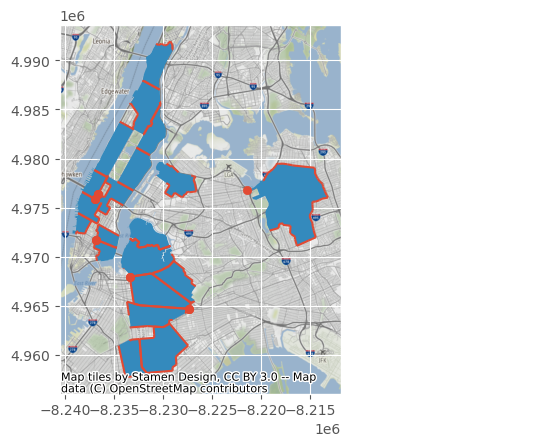

In [32]:
overlay_df = nyc_map.overlay(nyc_top20_count_map, how="intersection",keep_geom_type=False)
ax = overlay_df.plot()
cx.add_basemap(ax)

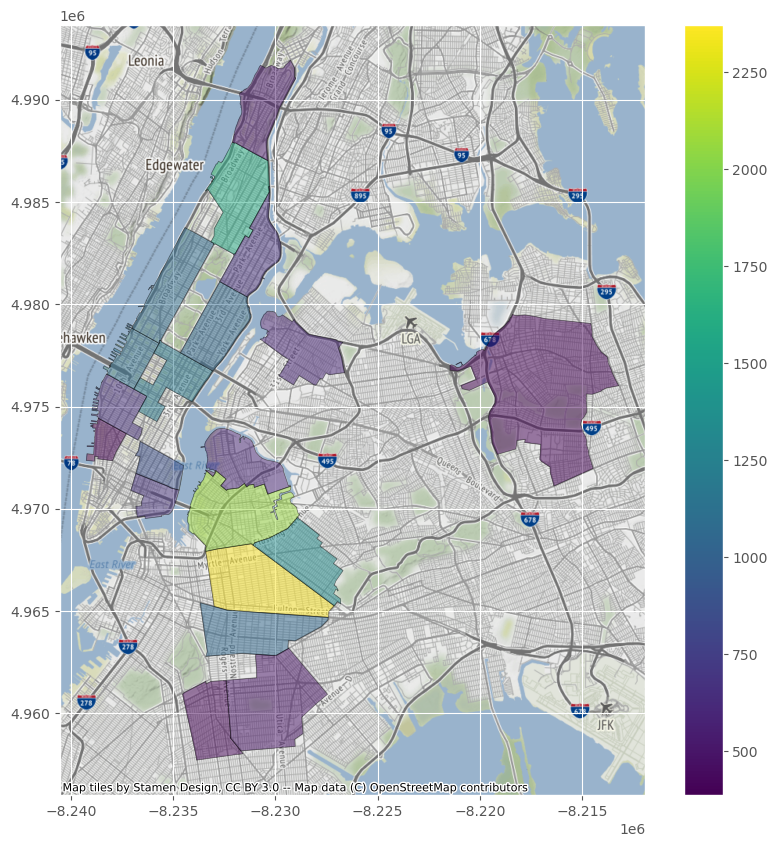

In [34]:
ax=nyc_top20_count_map.plot('neighborhood_count',figsize=(10, 10), alpha=0.5, edgecolor='k', legend=True)
cx.add_basemap(ax)

In [25]:
nyc_top20_price_map= nyc_map.merge(top_20_price, on='neighbourhood', how='inner')
nyc_top20_price_map=nyc_top20_price_map[nyc_top20_price_map['price']<3000]
nyc_top20_price_map.to_crs(epsg=3857, inplace=True)

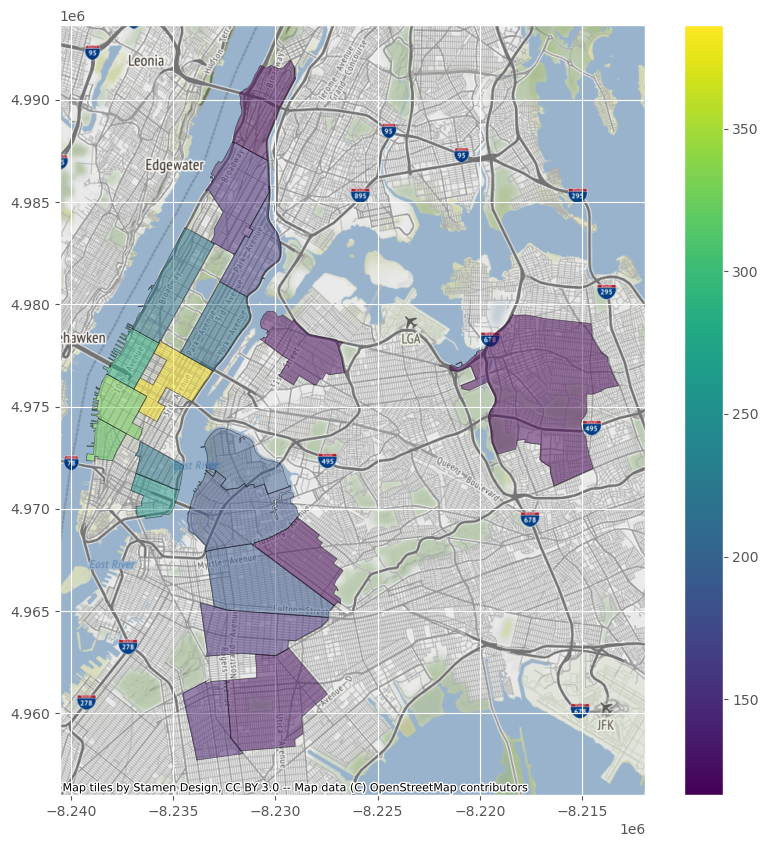

In [31]:
ax=nyc_top20_count_map.plot('price',figsize=(10, 10), alpha=0.5, edgecolor='k', legend=True)
cx.add_basemap(ax)

In [50]:
nyc_map_all= nyc_map.merge(neighborhood_means_and_counts, on='neighbourhood', how='inner')
nyc_map_all=nyc_map_all[nyc_map_all['price']<3000]
nyc_map_all.to_crs(epsg=3857, inplace=True)
nyc_map_all

neighbourhood neighbourhood_group  \
0             Bayswater              Queens   
1             Bayswater              Queens   
2              Allerton               Bronx   
3           City Island               Bronx   
4           City Island               Bronx   
..                  ...                 ...   
219  Westchester Square               Bronx   
220         Westerleigh       Staten Island   
221      Williamsbridge               Bronx   
222        Williamsburg            Brooklyn   
223         Willowbrook       Staten Island   

                                              geometry  neighborhood_count  \
0    MULTIPOLYGON (((-8211672.372 4955705.986, -821...                  21   
1    MULTIPOLYGON (((-8211489.474 4955509.042, -821...                  21   
2    MULTIPOLYGON (((-8220788.214 4993431.406, -822...                  45   
3    MULTIPOLYGON (((-8213466.174 4989346.939, -821...                  13   
4    MULTIPOLYGON (((-8213660.983 4991671.627, -821...                  13   
..                                                 ...                 ...   
219  MULTIPOLYGON (((-8220158.591 4989712.618, -821...                   7   
220  MULTIPOLYGON (((-8252259.681 4957380.390, -825...                   1   
221  MULTIPOLYGON (((-8222860.871 4993139.927, -822...                  64   
222  MULTIPOLYGON (((-8232919.255 4971877.704, -823...                2067   
223  MULTIPOLYGON (((-8254013.631 4954326.581, -825...                   1   

      latitude  longitude       price  
0    40.606350 -73.762886  100.904762  
1    40.606350 -73.762886  100.904762  
2    40.864974 -73.858897  112.244444  
3    40.849265 -73.787852  125.923077  
4    40.849265 -73.787852  125.923077  
..         ...        ...         ...  
219  40.842390 -73.847094   90.285714  
220  40.617850 -74.135200   91.000000  
221  40.878367 -73.856421  118.656250  
222  40.712410 -73.951810  184.217223  
223  40.599190 -74.133890  329.000000  

[222 rows x 7 columns]

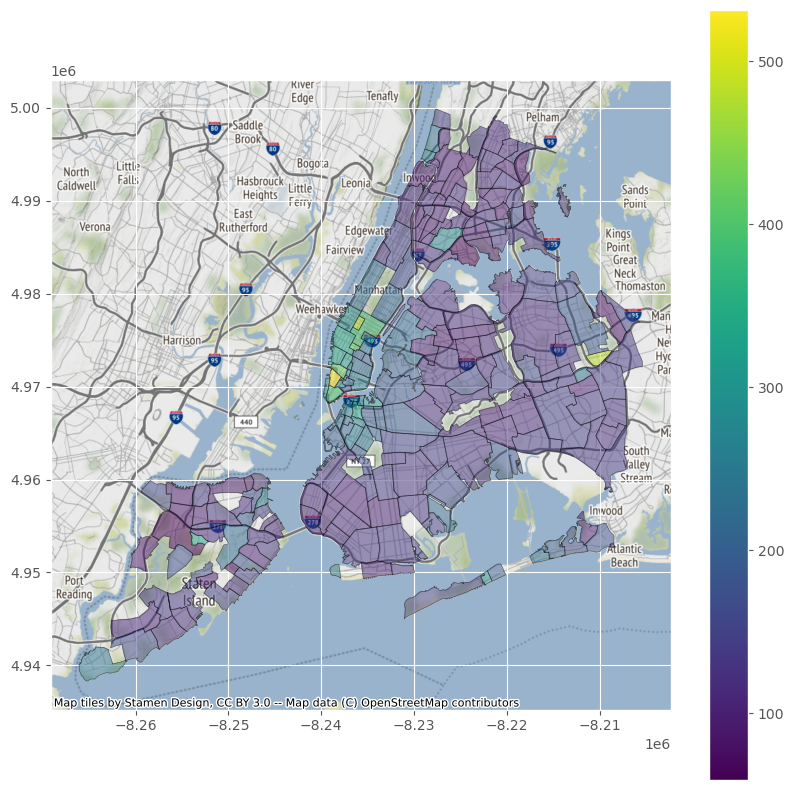

In [51]:
ax=nyc_map_all.plot('price',figsize=(10, 10), alpha=0.5, edgecolor='k', legend=True)
cx.add_basemap(ax)

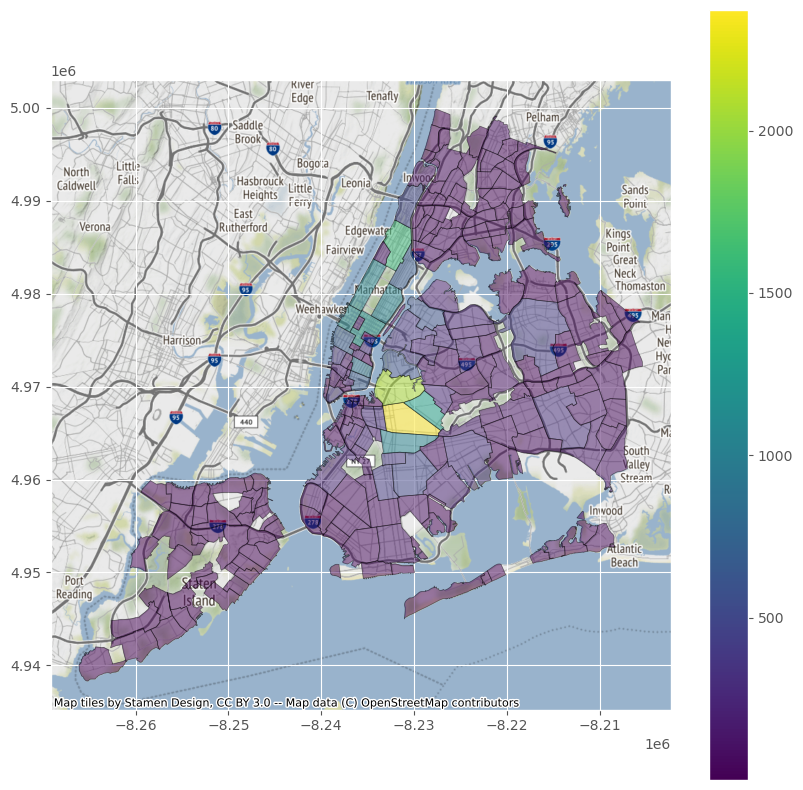

In [52]:
ax=nyc_map_all.plot('neighborhood_count',figsize=(10, 10), alpha=0.5, edgecolor='k', legend=True)
cx.add_basemap(ax)